In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib.patches import Rectangle

Some basic helper functions

In [3]:
def legcolor(leg):
    "function that gives back the color of legend elements, even if they are markers"
    for artist, text in zip(leg.legendHandles, leg.get_texts()):
            try:
                legcol = artist.get_color()
            except:
                legcol = artist.get_facecolor()
            if isinstance(legcol, np.ndarray):
                legcol = legcol[0]
            text.set_color(legcol)

In [4]:
#from old sam module, sam.ncopen
import netCDF4
def ncopen(filename, varnames, ind=slice(None)):
    "open ncfiles and load selected variables"

    if type(varnames) == str:
        varnames = [varnames]

    data = {}

    #ncfile = netCDF4.Dataset(filename)
    if type(filename) == str:
        ncfile = netCDF4.Dataset(filename)
    else:
        ncfile = netCDF4.MFDataset(filename)


    # load coords
    nind = ind if type(ind) == list else [ind]+3*[slice(None)]
    n = 0
    for coord in ['time','z','y','x']:
        try:
            data[coord] = ncfile.variables[coord][nind[n]]
            n += 1
        except (KeyError):
            #print('no {} dimension in file'.format(coord))
            pass

 #load variables
    for var in varnames:
        #print(ind)
        data[var] = ncfile.variables[var][ind]

    return data

Note for SAM output: the variable RADQRC is DIAGNOSTIC!
RADQRCLW and RADQRCSW are taken directly from the  code, so better use those variables

In [10]:
plt.rcParams.update({'font.size': 22}) #all to 22 if not specified other

#####IWP vs cloud cover plot#############
path2d ='../../data/radiative-transfer-model/' 
path2d ='/jetfs/scratch/bgasparini/DATA/SAM/cld_mid_domain/2D_acre/' 
varname = ['p','z','TABS','RADQR','RADQRLW','RADQRSW','SWNTOA','LWNTOA','LWNTOAC','SWNTOAC','LWNT','LWNS','LWDS','RADLWUP','RADLWDN',
           'RADSWUP','RADSWDN','CLD','RHO','RADQRCLW','RADQRCSW','RADQRC','QI']

names  = ['9p5-11p5km','12p25-14p25km'] #base temp 0.8 K warmer in the 305K case

temps = ['295','305']

col = ['k','crimson','dodgerblue','c']

var = ['RADQR','RADQRLW','RADQRSW'] #full sky
cvar = ['RADQRCLW','RADQRCLW','RADQRCSW'] #clear sky 


vvars = ['NET','LW','SW']
left = [0,10]
right = [9,19]

y1 = [9.5,12.25]
y2 = [11.5,14.25]
cod = ['SST=295','SST=305']
#############################
abc = ['a','b','c','d','e','f']
##################################

-------------------
cloud at  295 K at altitudes  9p5-11p5km
max HR= 5.652413
max HR= 1.1478317
15500.0
0 [5026.3154, 9500, 11500, 20000]
[36, 54, 62, 96] [ 5026.3154  9500.     11500.     20000.    ]
-------------------
cloud at  305 K at altitudes  12p25-14p25km
max HR= 8.181584
max HR= 1.6121957
17000.0
1 [5026.3154, 12250, 14250, 20000]
[36, 65, 73, 96] [ 5026.3154 12250.     14250.     20000.    ]


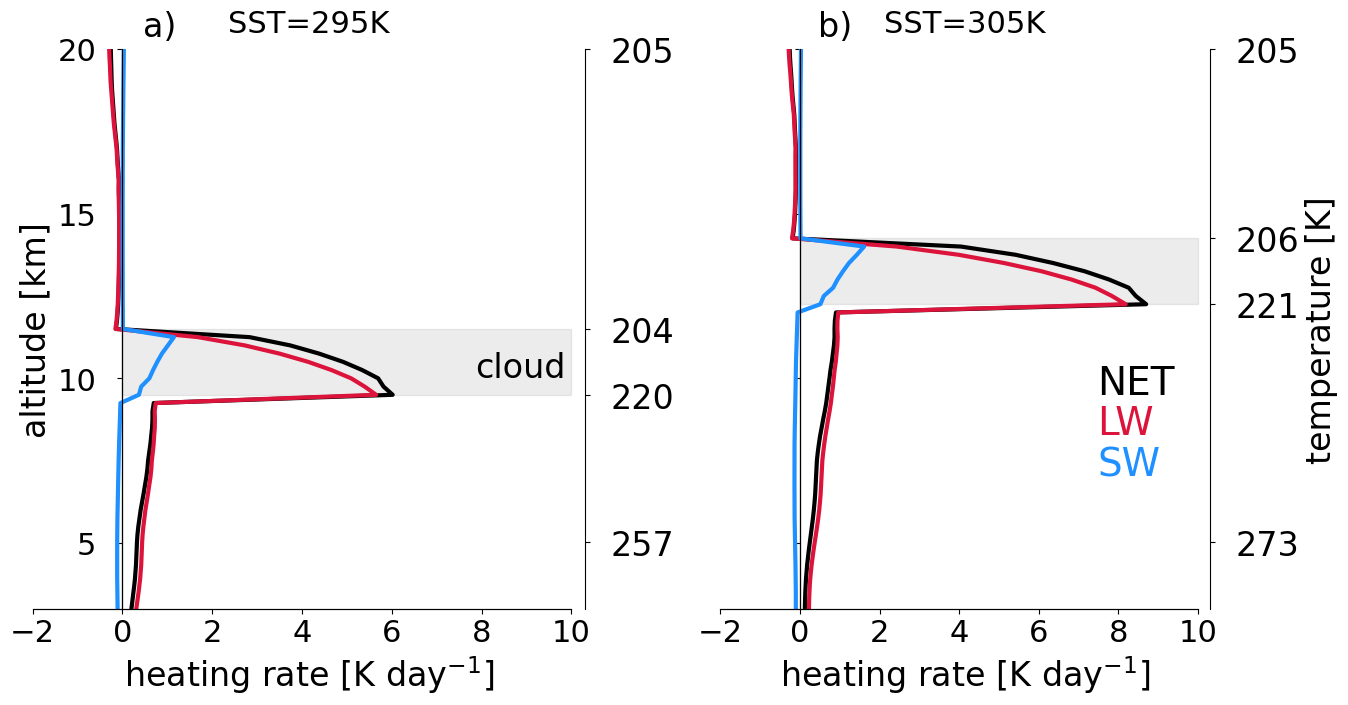

In [11]:
left = [0,11]
right = [9,19]


fig = plt.figure()
fig.set_size_inches(16, 16, forward=True)
gs = gridspec.GridSpec(2, 20, height_ratios=[1, 1], width_ratios=20 * [1])
for t, name in enumerate(names):
    print('-------------------')
    print('cloud at ', temps[t], 'K', 'at altitudes ', name)

    ax = fig.add_subplot(gs[0, left[t]:right[t]])
    data_2d = ncopen(path2d + 'BARcirrus_' + temps[t] + 'K_P3_128x128_cld8_r20-r30_' + name + '_cod1.nc', varname,
                         ind=slice(None))
    alt = data_2d['z'].squeeze()

    for v in range(0, 3):
        if v == 0:
            qrad = data_2d[var[v]][0].squeeze() - data_2d[cvar[0]][0].squeeze() - data_2d[cvar[2]][0].squeeze()
        else:
            qrad = data_2d[var[v]][0].squeeze() - data_2d[cvar[v]][0].squeeze()
            print('max HR=', np.max(qrad))

        plt.plot(qrad, alt / 1000, color=col[v], linewidth=3)
        plt.ylim(3, 20)
        plt.xlim(-0.5, 10)

    plt.axvline(0, color='grey', linewidth=1.)
    ax.get_xaxis().set_ticks([-2, 0, 2, 4, 6, 8, 10])
    if t == 0:
        plt.ylabel('altitude [km]', size=24)
        ax.tick_params(axis='y', which='major', pad=15)
        ax.get_yaxis().set_ticks([5, 10, 15, 20])
        plt.text(0.965, 0.46, 'cloud', transform=ax.transAxes, horizontalalignment='right',
                 verticalalignment='top', fontsize=24, color='black')
    if t == 1:
        ax.get_yaxis().set_ticks([5, 10, 15, 20])
        ax.get_yaxis().set_ticklabels([])
        leg = plt.legend(vvars, loc='best', fontsize=28, frameon=False, handlelength=0,
                         markerscale=0, labelspacing=0.07, bbox_to_anchor=(0.5, 0., 0.5, 0.5))  # prop=legend_properties)
        legcolor(leg)
        leg.set_zorder(0)
        ax.add_patch(Rectangle((6, 6), 1.5, 5, color='white', alpha=1))  # white shading over legend dots

    ax.add_patch(Rectangle((0, y1[t]), 10, 2, color='gray', alpha=0.15))  # cloud shading
    plt.xlabel('heating rate [K day$^{-1}$]', size=24)
    plt.title('' + cod[t] + 'K', size=22, y=1.015)

    plt.text(0.2, 1.07, abc[t] + ')', transform=ax.transAxes, horizontalalignment='left',
             verticalalignment='top', fontsize=24, color='black', bbox=dict(facecolor='white', edgecolor='none', pad=1))

    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(-2., 10)

    # Create a twin y-axis for temperature
    ax2 = ax.twinx()
    ax2.set_ylim(3, 20)
    ax2.set_xlim(-2, 10.3)
    if t==1:
        ax2.set_ylabel('temperature [K]', size=24)
    ax2.tick_params(axis='y', which='major', pad=15)

    # Plot temperature values on the temperature y-axis
    temp_values = temp = data_2d['TABS'][0].squeeze()  # data_2d['TABS'][0].squeeze()
    tminalt=alt[np.argmin(temp_values)]
    print(tminalt)
    # Set temperature values as y-axis tick labels
    if t == 0:
        alt1 = [5026.3154, 9500, 11500,20000]#tminalt]
    else:
        alt1 = [5026.3154, 12250, 14250, 20000]#tminalt]
    alt2 = [val -3000 for val in alt1]  #because axis starts at 3 km!
    #print(alt2)
    ax2.set_yticks(alt2)  # Set tick locations based on altitude values
    
    
    print(t,alt1)
    alt_indices = [np.abs(alt - val).argmin() for val in alt1]  # Convert alt1 values to indices
    print(alt_indices,alt[alt_indices])
    #alt_indices = [index - 14 for index in alt_indices]  # Subtract 4 from each index
    ax2.set_yticklabels([f'{temp_values[i]:.0f}' for i in alt_indices], fontsize=24)
    
    # Remove top and right plot boundary lines
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_bounds(-2., 10)
    

#plt.savefig('/path-to-fig/Fig1_radiative_calculations_cloud.pdf',bbox_inches='tight')

##Same but in pressure space

-------------------
cloud at  295 K at altitudes  9p5-11p5km
max HR= 5.652413
max HR= 1.1478317
-------------------
cloud at  305 K at altitudes  12p25-14p25km
max HR= 8.181584
max HR= 1.6121957


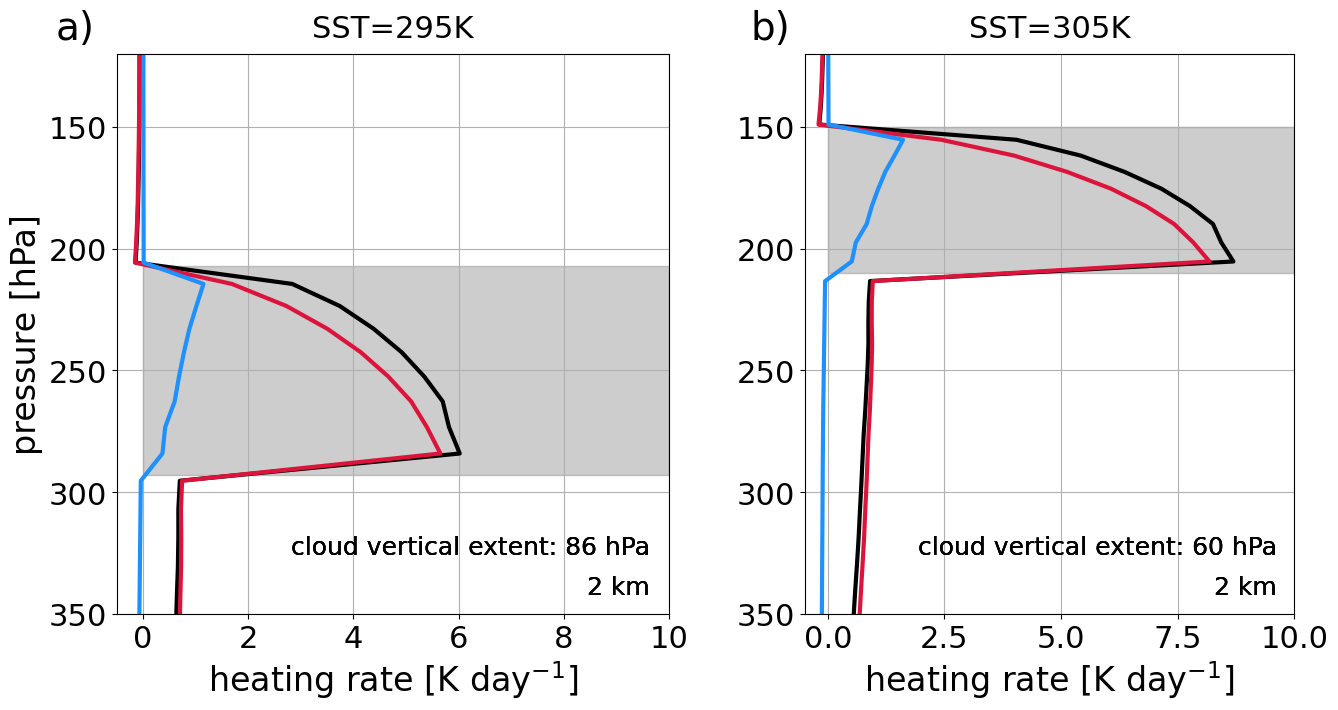

In [47]:
left = [0,11]
right = [9,19]

ctop = [207,150]
cextent=[86,60]
abcd = ['a','b','c','d']

fig = plt.figure()
fig.set_size_inches(16, 16, forward=True)
gs = gridspec.GridSpec(2, 20, height_ratios=[1, 1], width_ratios=20 * [1])
for t, name in enumerate(names):
    print('-------------------')
    print('cloud at ', temps[t], 'K', 'at altitudes ', name)

    ax = fig.add_subplot(gs[0, left[t]:right[t]])
    data_2d = ncopen(path2d + 'BARcirrus_' + temps[t] + 'K_P3_128x128_cld8_r20-r30_' + name + '_cod1.nc', varname,
                         ind=slice(None))
    alt = data_2d['z'].squeeze()
    pres = data_2d['p'].squeeze()

    for v in range(0, 3):
        if v == 0:
            qrad = data_2d[var[v]][0].squeeze() - data_2d[cvar[0]][0].squeeze() - data_2d[cvar[2]][0].squeeze()
        else:
            qrad = data_2d[var[v]][0].squeeze() - data_2d[cvar[v]][0].squeeze()
            print('max HR=', np.max(qrad))

        plt.plot(qrad, pres, color=col[v], linewidth=3)
        plt.xlim(-0.5, 10)
        #plt.yscale('log')
        plt.gca().invert_yaxis()
        plt.ylim(350,120)
        plt.grid(True)

        ax.add_patch(Rectangle((0, ctop[t]), 10, cextent[t], color='gray', alpha=0.15))  # cloud shading
        #ax.add_patch(Rectangle((0, 150), 10, 60, color='y', alpha=0.15))  # cloud shading
        plt.xlabel('heating rate [K day$^{-1}$]', size=24)
        plt.title('' + cod[t] + 'K', size=22, y=1.015)        

        plt.text(0.965, 0.14, 'cloud vertical extent: ' + str(cextent[t]) + ' hPa', transform=ax.transAxes, horizontalalignment='right',
                 verticalalignment='top', fontsize=18, color='black')
        plt.text(0.965, 0.07, '2 km', transform=ax.transAxes, horizontalalignment='right',
                 verticalalignment='top', fontsize=18, color='black')        
    if t == 0:
        plt.ylabel('pressure [hPa]', size=24)        
    plt.text(-0.11,1.08,abcd[t]+')',transform=ax.transAxes,horizontalalignment='left',
                 verticalalignment='top',fontsize=28,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))         
#plt.savefig('/path-to-fig/Fig1_radiative_calculations_cloud.pdf',bbox_inches='tight')
plt.savefig('/jetfs/home/bgasparini/figures/rcemip/review/GRL_FigS1_pressure-space-crh.pdf',dpi=200,bbox_inches='tight')

-------------------
cloud at  295 K at altitudes  9p5-11p5km
-------------------
cloud at  305 K at altitudes  12p25-14p25km


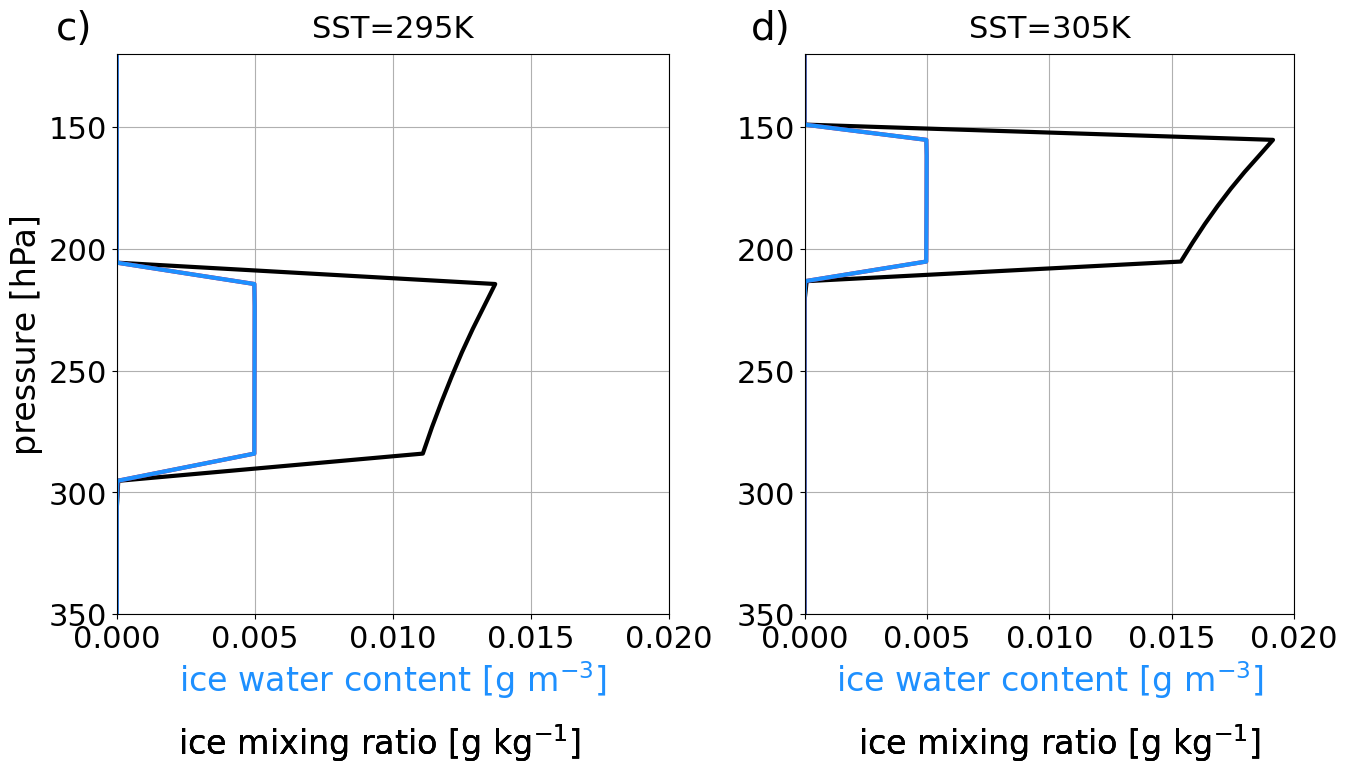

In [45]:
left = [0,11]
right = [9,19]

ctop = [207,150]
cextent=[86,60]


fig = plt.figure()
fig.set_size_inches(16, 16, forward=True)
gs = gridspec.GridSpec(2, 20, height_ratios=[1, 1], width_ratios=20 * [1])
for t, name in enumerate(names):
    print('-------------------')
    print('cloud at ', temps[t], 'K', 'at altitudes ', name)

    ax = fig.add_subplot(gs[0, left[t]:right[t]])
    data_2d = ncopen(path2d + 'BARcirrus_' + temps[t] + 'K_P3_128x128_cld8_r20-r30_' + name + '_cod1.nc', varname,
                         ind=slice(None))
    alt = data_2d['z'].squeeze()
    pres = data_2d['p'].squeeze()

    for v in range(0, 3):
        if v == 0:
            qrad = data_2d['QI'][0].squeeze()
        else:
            qrad = data_2d['QI'][0].squeeze()*data_2d['RHO'][0].squeeze()
            #print('max HR=', np.max(qrad))

        plt.plot(qrad, pres, color=col[v], linewidth=3)
        plt.xlim(0,0.02)
        #plt.yscale('log')
        plt.gca().invert_yaxis()
        plt.ylim(350,120)
        plt.grid(True)

        plt.xlabel('ice water content [g m$^{-3}$]', color='dodgerblue', size=24)
        plt.text(0.11, -0.25, 'ice mixing ratio [g kg$^{-1}$]', transform=ax.transAxes,fontsize=24, color='black')
        #fig.text(0.15, 0.02, 'Second X-axis Label', ha='center', size=24)
        plt.title('' + cod[t] + 'K', size=22, y=1.015)        
    
    if t == 0:
        plt.ylabel('pressure [hPa]', size=24) 
        
    plt.text(-0.11,1.08,abcd[t+2]+')',transform=ax.transAxes,horizontalalignment='left',
                 verticalalignment='top',fontsize=28,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))        
#plt.savefig('/path-to-fig/Fig1_radiative_calculations_cloud.pdf',bbox_inches='tight')
plt.savefig('/jetfs/home/bgasparini/figures/rcemip/review/GRL_FigS1cd_pressure-space-crh.pdf',dpi=200,bbox_inches='tight')

In [21]:
data_2d

{'time': masked_array(data=[5.7870369e-05, 1.7361112e-04, 2.8935185e-04,
                    4.0509258e-04, 5.2083336e-04],
              mask=False,
        fill_value=1e+20,
             dtype=float32),
 'z': masked_array(data=[2.5000000e+01, 5.0000000e+01, 1.0526315e+02,
                    1.6052631e+02, 2.2631575e+02, 2.9210519e+02,
                    3.6842096e+02, 4.4473672e+02, 5.3157880e+02,
                    6.1842090e+02, 7.1578931e+02, 8.1315771e+02,
                    9.2105249e+02, 1.0289473e+03, 1.1473684e+03,
                    1.2657894e+03, 1.3947368e+03, 1.5236841e+03,
                    1.6631577e+03, 1.8026315e+03, 1.9526316e+03,
                    2.1026316e+03, 2.2631580e+03, 2.4236843e+03,
                    2.5947368e+03, 2.7657896e+03, 2.9473687e+03,
                    3.1289475e+03, 3.3210527e+03, 3.5131580e+03,
                    3.7157896e+03, 3.9184211e+03, 4.1315791e+03,
                    4.3447368e+03, 4.5684209e+03, 4.7921050e+03,
          